## Прогнозирование количества заказов такси на следующий час

Собраны исторические данные о заказах таксикомпании «Чётенькое такси»  в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, будет спрогнозировано количество заказов такси на следующий час (для этого будет построена модель для предсказания). 

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Инструкция по выполнению проекта

    1. Загрузить данные и выполнить их ресемплирование по одному часу.
    
    2. Проанализировать данные.
    
    3. Обучить разные модели с различными гиперпараметрами. Сделайть тестовую выборку размером 10% от исходных данных.
    Проверить данные на тестовой выборке и сделайть выводы.

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import itertools
import math
import time

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.datasets import make_spd_matrix
from joblib import dump
pd.options.mode.chained_assignment = None

pd.set_option('display.max_columns', None)

## 1. Загрузка и подготовка данных

Загрузим данные и сразу колонку с датами заказов переведем в индекс таблицы. Так же отсортируем индекс таблицы. Выполним ресемплирование временного ряда (сумма по каждому часу). И конечно познакомимся с данными.

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
except:
    df = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])
    
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<AxesSubplot:xlabel='datetime'>

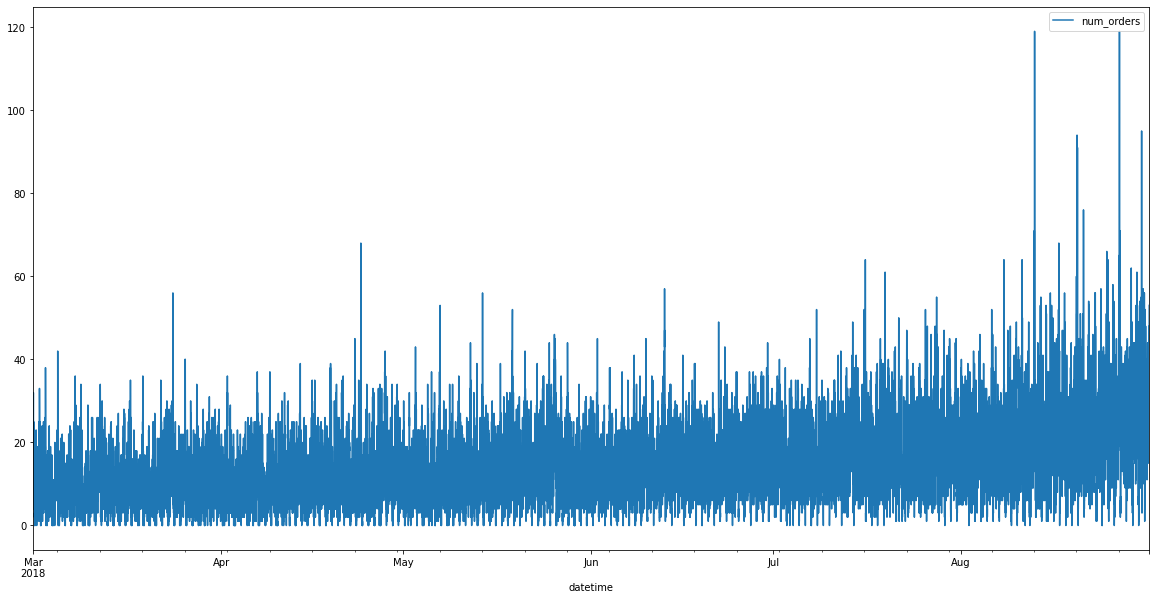

In [9]:
df.plot(figsize=(20, 10))

In [10]:
df.index.is_monotonic

True

In [11]:
df.sort_index(inplace=True)

In [12]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

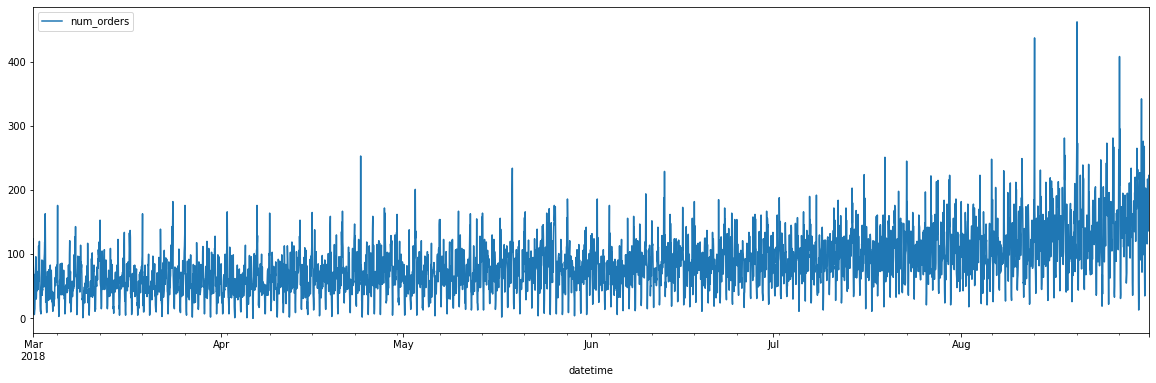

In [13]:
df.plot(figsize=(20, 6))

<AxesSubplot:xlabel='datetime'>

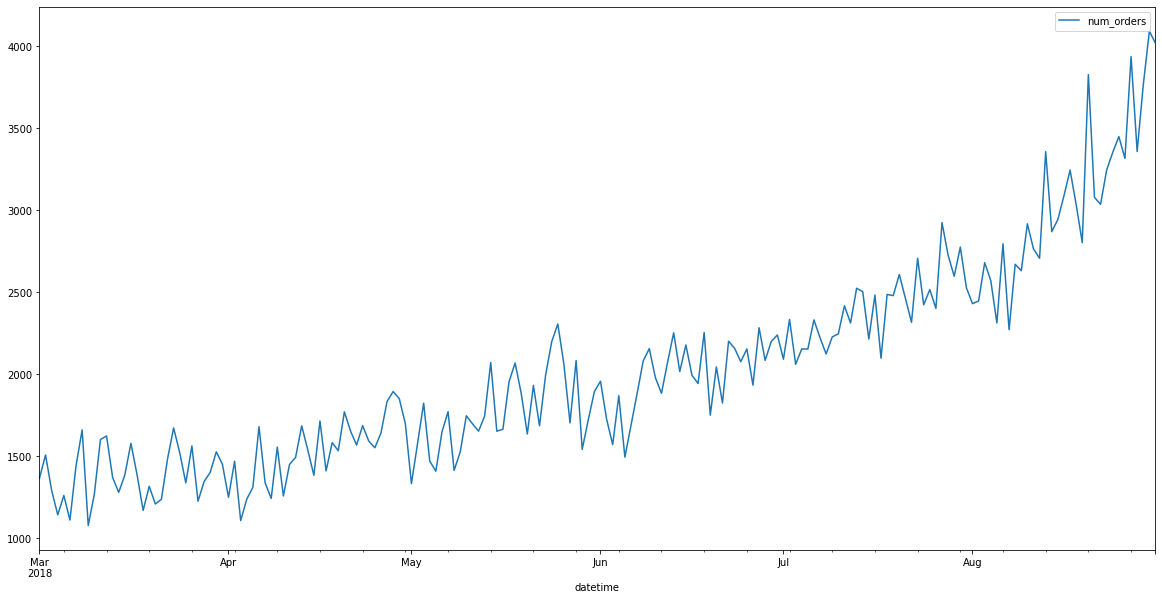

In [14]:
df.resample('1D').sum().plot(figsize=(20, 10))

In [15]:
df.isna().sum()

num_orders    0
dtype: int64

In [16]:
df[df['num_orders'] == 0]

,num_orders
datetime,
2018-04-06 06:00:00,0


Посмотрели данные, есть ли часы, где заказов не было совсем в течении часа. Как видно, это было единожды около 6 часов утра, что вполне может случиться.

## 2. Анализ данных

Посмотрим скользящую среднюю за сутки (24 часа):

<AxesSubplot:xlabel='datetime'>

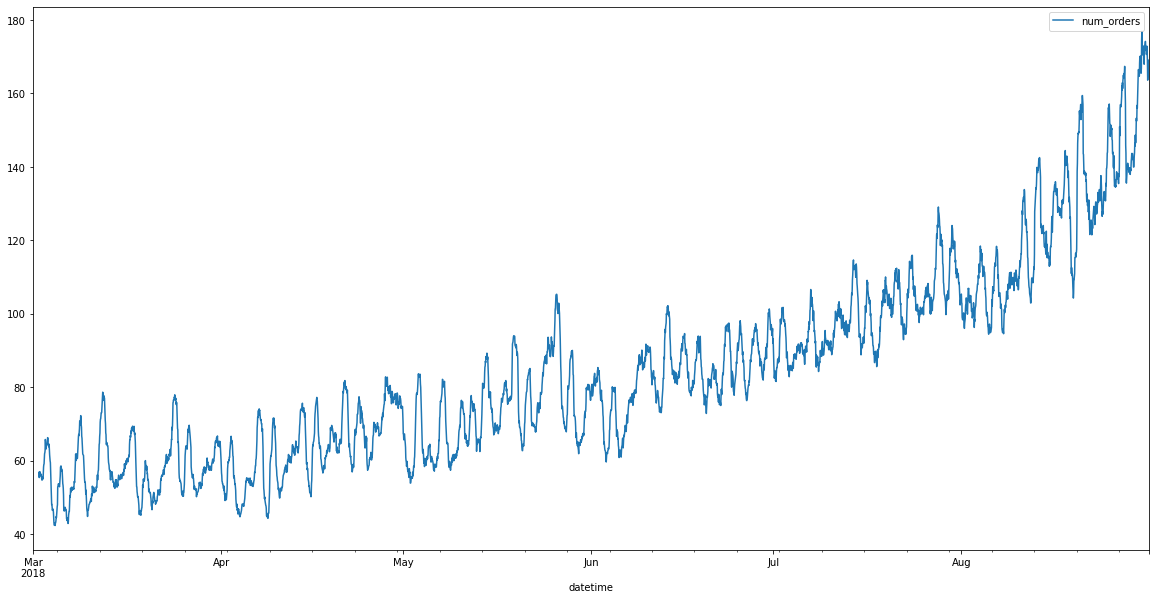

In [19]:
df.rolling(24).mean().plot(figsize=(20, 10))

Построим графики и посмотрим так же тренды и сезонность:

In [20]:
decomposed = seasonal_decompose(df)

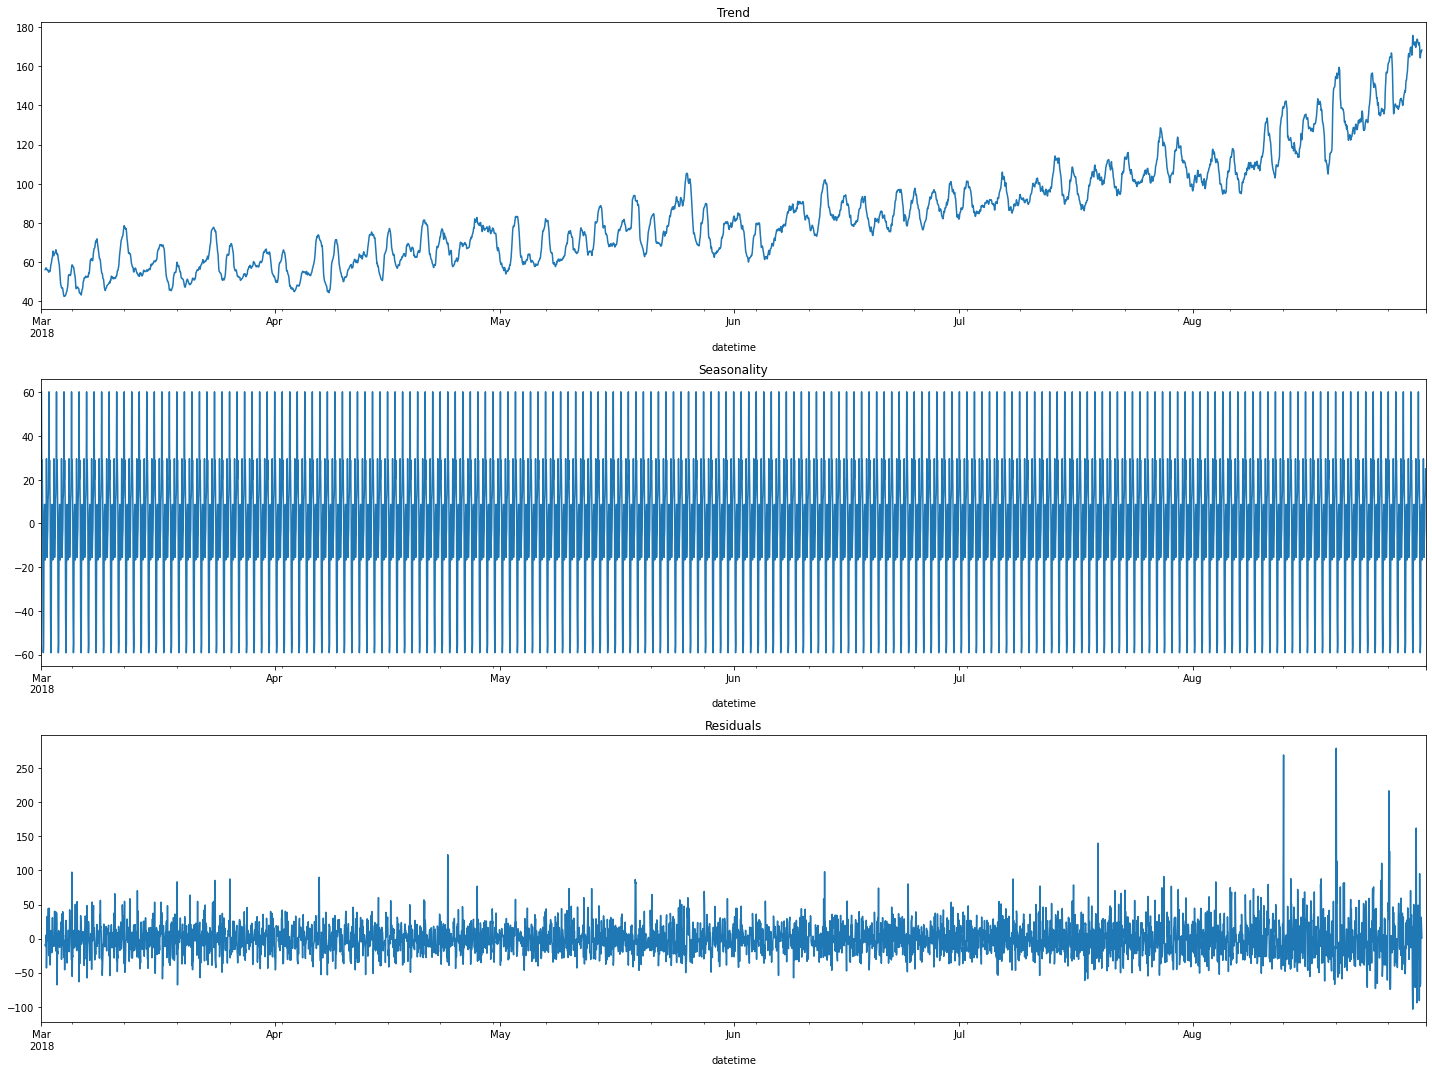

In [21]:
plt.figure(figsize=(20, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь построим график сезонной составляющей за пару дней, неледю и за месяц.

<AxesSubplot:xlabel='datetime'>

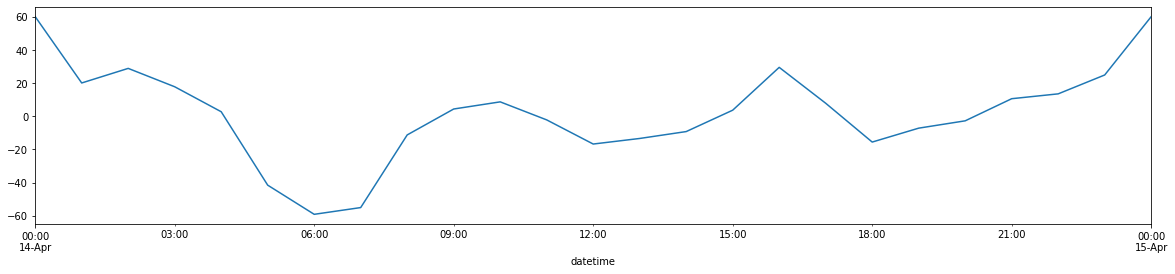

In [22]:
plt.figure(figsize=(20, 4))
decomposed.seasonal['2018-04-14 00:00:00':'2018-04-15 00:00:00'].plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

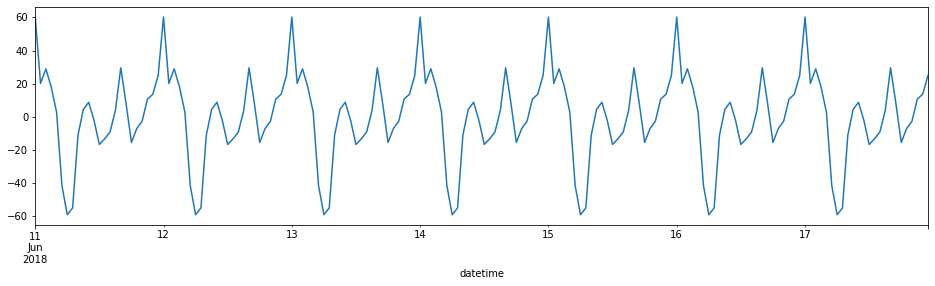

In [23]:
plt.figure(figsize=(16, 4))
decomposed.seasonal['2018-06-11':'2018-06-17'].plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

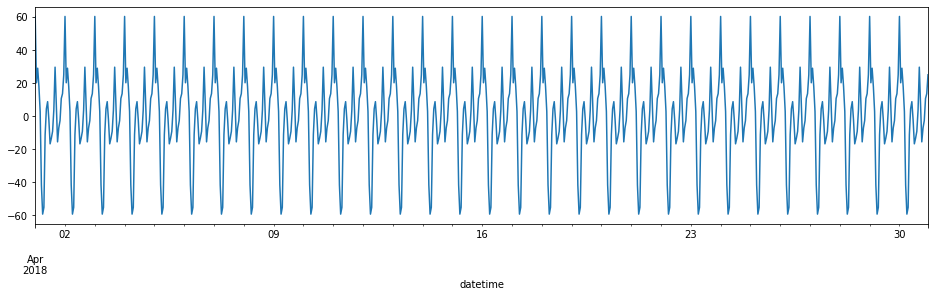

In [24]:
plt.figure(figsize=(16, 4))
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(ax=plt.gca())

Как видно из графиков, ежедневно спрос растет и падает в одни и теже часы: в полночть и 6 утра соответственно. Тренд растущий.

## 3. Построение моделей

### Созданире признаков и подготовка данных

Создадим признаки через написание функции:
год, месяц, день, день недели, отстающие значения и  колонку со скользящей средней.

Проводим анализ:    
1) Фактор год: не подходит. У нас данных меньше года. Поэтому будет просто константа.   
2) Фактор месяц: не подходит, у нас в истории всего один март, май.... Да и горизонт прогноза - часы.   
3) Фактор день: скорее нет, будет просто последовательность чисел   
4) Фактор день недели: подходит, т.к. у нас есть недельная сезонность   
5) Фактор час: подходит, т.к. есть часовая (суточная) сезонность.   
6) Факто lag: подходит, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.    
7) Фактор rolling: подходит, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда</font>

In [25]:
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
    
df['lag_12'] = df['num_orders'].shift(12)
df['lag_24'] = df['num_orders'].shift(24)

df['rolling_mean'] = df['num_orders'].shift().rolling(16).mean()

In [26]:
df = df.dropna()

In [27]:
df.head()

,num_orders,dayofweek,hour,lag_12,lag_24,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,30.0,124.0,58.8750
2018-03-02 01:00:00,120,4,1,32.0,85.0,62.3750
2018-03-02 02:00:00,75,4,2,48.0,71.0,65.5625
2018-03-02 03:00:00,64,4,3,66.0,66.0,66.2500
2018-03-02 04:00:00,20,4,4,43.0,43.0,64.2500


Далее разделим выборку на обучающую, валидационную и тестовую в соотношении 80%, 10% и 10%. Так же разделим на признаки и целевой признак.

In [28]:
train, test = train_test_split(df, shuffle=False, test_size=0.20)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)

In [29]:
print(train.shape)
print(valid.shape)
print(test.shape)

(3513, 6)
(439, 6)
(440, 6)


In [30]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-07-26 08:00:00
2018-07-26 09:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [31]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Линейная регрессия

In [30]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
rmse = math.sqrt(mean_squared_error(target_valid, predictions))
print('RMSE равно:', rmse)

RMSE равно: 37.77939625534931


Результат RMSE ~ 38

### Случайный лес

In [35]:
for depth,estimator in itertools.product(range(10,51,10), range(10,511,20)):
    model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=estimator)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = math.sqrt(mean_squared_error(target_valid, predictions))
    print('Depth, Estimator:', depth, ', ', estimator)
    print('Accuracy:', rmse)
    print('     ')

Depth, Estimator: 10 ,  10
Accuracy: 33.81777530354085
     
Depth, Estimator: 10 ,  30
Accuracy: 33.010717327064775
     
Depth, Estimator: 10 ,  50
Accuracy: 32.976972371324585
     
Depth, Estimator: 10 ,  70
Accuracy: 32.788899631651766
     
Depth, Estimator: 10 ,  90
Accuracy: 32.673623223509445
     
Depth, Estimator: 10 ,  110
Accuracy: 32.72749529618383
     
Depth, Estimator: 10 ,  130
Accuracy: 32.715371227066704
     
Depth, Estimator: 10 ,  150
Accuracy: 32.66930466613189
     
Depth, Estimator: 10 ,  170
Accuracy: 32.591183322089265
     
Depth, Estimator: 10 ,  190
Accuracy: 32.536254069391774
     
Depth, Estimator: 10 ,  210
Accuracy: 32.4473208172381
     
Depth, Estimator: 10 ,  230
Accuracy: 32.459973717386546
     
Depth, Estimator: 10 ,  250
Accuracy: 32.483807182781284
     
Depth, Estimator: 10 ,  270
Accuracy: 32.4542543786908
     
Depth, Estimator: 10 ,  290
Accuracy: 32.468029104375944
     
Depth, Estimator: 10 ,  310
Accuracy: 32.512302945148406
     
Dept

Лучший результат RMSE ~ 32

### Случайный лес с TimeSeriesSplit

In [44]:
clf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=10)
grid_parametrs = { 'n_estimators': range (0, 201, 20), 
                  'max_depth': range (0, 101, 10) }
gsearch = GridSearchCV(estimator=clf, cv=tscv,  param_grid=grid_parametrs, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gsearch.fit(features_train, target_train)

Fitting 10 folds for each of 121 candidates, totalling 1210 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(0, 101, 10),
                         'n_estimators': range(0, 201, 20)},
             scoring='neg_mean_squared_error', verbose=1)

In [45]:
gsearch.best_params_

{'max_depth': 80, 'n_estimators': 200}

In [46]:
gsearch.best_score_

-519.4038168103449

In [47]:
model = RandomForestRegressor(n_estimators=200, max_depth=80, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
rmse = math.sqrt(mean_squared_error(target_valid, predictions))
print('RMSE равно:', rmse)

RMSE равно: 32.141509844254934


Попробую сразу же проверить на тестовой выборке:

In [48]:
model = RandomForestRegressor(n_estimators=200, max_depth=80, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = math.sqrt(mean_squared_error(target_test, predictions))
print('RMSE равно:', rmse)

RMSE равно: 54.62262782970742


### Градиентный бустинг LightGBM

In [36]:
lgbm_model = LGBMRegressor(num_leaves=290, max_depth=20, random_state=12345)
lgbm_model.fit(features_train, target_train)
predictions = lgbm_model.predict(features_valid)
rmse = math.sqrt(mean_squared_error(target_valid, predictions))
print('RMSE равно:', rmse)

RMSE равно: 31.173064446072118


Результат RMSE ~ 31

### Расчёт DummyRegressor

In [37]:
dummy_median = DummyRegressor(strategy = 'median').fit(features_train, target_train)
dummy_mean = DummyRegressor(strategy = 'mean').fit(features_train, target_train)
predictions_dummy_median = dummy_median.predict(features_valid) 
predictions_dummy_mean = dummy_mean.predict(features_valid)
rmse_median = math.sqrt(mean_squared_error(target_valid, predictions_dummy_median))
rmse_mean = math.sqrt(mean_squared_error(target_valid, predictions_dummy_mean))

In [38]:
print('RMSE median:', rmse_median)
print('RMSE mean:', rmse_mean)

RMSE median: 59.96346647812227
RMSE mean: 58.42982951650663


Результатs RMSE ~ 60 и 58 соответственно.

Лучший результат показал градиентный бустинг LightGBM с RMSE ~ 31, поэтому ниже на LightGBM будет проведена проверка на тестовой выборке. 

## Проверка на тестовой выборке

Градиентный бустинг LightGBM:

In [41]:
for depth,estimator in itertools.product(range(10,51,10), range(10,511,20)):
    lgbm_model = LGBMRegressor(random_state=12345, max_depth=depth, n_estimators=estimator)
    lgbm_model.fit(features_train, target_train)
    predictions = lgbm_model.predict(features_test)
    rmse = math.sqrt(mean_squared_error(target_test, predictions))
    print('Depth, Estimator:', depth, ', ', estimator)
    print('Accuracy:', rmse)
    print('     ')

Depth, Estimator: 10 ,  10
Accuracy: 66.80230223156805
     
Depth, Estimator: 10 ,  30
Accuracy: 56.84118997400149
     
Depth, Estimator: 10 ,  50
Accuracy: 54.85898939816153
     
Depth, Estimator: 10 ,  70
Accuracy: 54.41106164286651
     
Depth, Estimator: 10 ,  90
Accuracy: 53.76761842034927
     
Depth, Estimator: 10 ,  110
Accuracy: 53.45312915742632
     
Depth, Estimator: 10 ,  130
Accuracy: 52.9951329160566
     
Depth, Estimator: 10 ,  150
Accuracy: 52.42329981015069
     
Depth, Estimator: 10 ,  170
Accuracy: 52.50101815568927
     
Depth, Estimator: 10 ,  190
Accuracy: 52.173968313554525
     
Depth, Estimator: 10 ,  210
Accuracy: 51.92307948516424
     
Depth, Estimator: 10 ,  230
Accuracy: 51.79044007542183
     
Depth, Estimator: 10 ,  250
Accuracy: 51.73077147312458
     
Depth, Estimator: 10 ,  270
Accuracy: 51.72586425254884
     
Depth, Estimator: 10 ,  290
Accuracy: 51.772489701698106
     
Depth, Estimator: 10 ,  310
Accuracy: 51.677407396824414
     
Depth, Esti

Результат оказался очень плохим RMSE ~ 50, поэтому попробую на других моделях.

Линейная регрессия:

In [39]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = math.sqrt(mean_squared_error(target_test, predictions))
print('RMSE равно:', rmse)

RMSE равно: 49.849979446607946


На линейной регресси результат такой же плохой: RMSE ~ 50.

Случайный лес:

In [42]:
for depth,estimator in itertools.product(range(10,51,10), range(10,511,20)):
    model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=estimator)
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    rmse = math.sqrt(mean_squared_error(target_test, predictions))
    print('Depth, Estimator:', depth, ', ', estimator)
    print('Accuracy:', rmse)
    print('     ')

Depth, Estimator: 10 ,  10
Accuracy: 56.616488781529426
     
Depth, Estimator: 10 ,  30
Accuracy: 55.38104378407116
     
Depth, Estimator: 10 ,  50
Accuracy: 55.212630625461195
     
Depth, Estimator: 10 ,  70
Accuracy: 55.62544955728822
     
Depth, Estimator: 10 ,  90
Accuracy: 55.312394183973375
     
Depth, Estimator: 10 ,  110
Accuracy: 55.446115759654695
     
Depth, Estimator: 10 ,  130
Accuracy: 55.26177246084483
     
Depth, Estimator: 10 ,  150
Accuracy: 55.40411384392988
     
Depth, Estimator: 10 ,  170
Accuracy: 55.22591575803003
     
Depth, Estimator: 10 ,  190
Accuracy: 55.175063878575656
     
Depth, Estimator: 10 ,  210
Accuracy: 55.143708789623616
     
Depth, Estimator: 10 ,  230
Accuracy: 55.24124463821462
     
Depth, Estimator: 10 ,  250
Accuracy: 55.133056895331286
     
Depth, Estimator: 10 ,  270
Accuracy: 54.98374314906789
     
Depth, Estimator: 10 ,  290
Accuracy: 55.08546562201983
     
Depth, Estimator: 10 ,  310
Accuracy: 55.174600903604876
     
Depth

## Вывод

В данном проекте надо было спрогнозировать нагрузку на компанию такси (количество заказов) для чего были использованы несколько моделей. Результаты представлены ниже:

Линейная регрессия: RMSE ~ 38

Случайный лес: RMSE ~ 32

Гр. бустинг LightGBM: RMSE ~ 31

DummyRegressor:  RMSE ~ 60 и 58 медиана и среднее соответственно

**Результаты на тестовой выборке:**

Гр. бустинг LightGBM: RMSE ~ 50

Линейная регрессия: RMSE ~ 50

Случайный лес: RMSE ~ 54

Лучший результат показал градиентный бустинг LightGBM